## Package Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import f_oneway
pd.pandas.set_option('display.max_columns', None) 
sns.set_theme(color_codes = True)

import os
import sys
import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# ELO
from ELO import ELO

# sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

# pytorch
import torch
print(torch.cuda.is_available())

# Wandb
import wandb
wandb.login(key = '95d4fb2d02fe3866b9b32239df088d24cccd2efe')
from CatBoostWandbCallback import CatBoostWandbCallback

# Catboost
from catboost import Pool, CatBoostClassifier

# Optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.integration import CatBoostPruningCallback

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(True)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
seed_everything(SEED)

True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jw0112 (teemo-dkt). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/.netrc


## Load Preprocessed Data

In [2]:
data = pd.read_parquet('./data/data_preprocessed.parquet')
data

,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,year,month,day,hour,dow,weekday,ElapsedTime,ElapsedTime_Rolling2,ElapsedTime_Rolling3,ElapsedTime_Rolling4,ElapsedTime_Rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problemID_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,Correct_User_ElapsedTime,Wrong_User_ElapsedTime,user_sum,user_cnt,user_acc,user_itemID_sum,user_itemID_cnt,user_itemID_acc,user_testID_sum,user_testID_cnt,user_testID_acc,user_testCode_sum,user_testCode_cnt,user_testCode_acc,user_testNum_sum,user_testNum_cnt,user_testNum_acc,user_problemID_sum,user_problemID_cnt,user_problemID_acc,user_tag_sum,user_tag_cnt,user_tag_acc,itemID_sum,itemID_cnt,itemID_acc,testID_sum,testID_cnt,testID_acc,testCode_sum,testCode_cnt,testCode_acc,testNum_sum,testNum_cnt,testNum_acc,problemID_sum,problemID_cnt,problemID_acc,tag_sum,tag_cnt,tag_acc,itemID_high_freq,testID_high_freq,testCode_high_freq,testNum_high_freq,problemID_high_freq,tag_high_freq,user_past_solved,relative_correct_rate,is_correct_before1,correct_rate_before1,relative_correct_rate_before1,is_correct_before2,correct_rate_before2,relative_correct_rate_before2,is_correct_before3,correct_rate_before3,relative_correct_rate_before3,is_correct_before4,correct_rate_before4,relative_correct_rate_before4,is_correct_before5,correct_rate_before5,relative_correct_rate_before5,theta,beta
0,0,A060001001,1,7224,060001,6,1,1,0.000000,2020,3,24,0,1,1,3.000000,0.000000,0.000000,0.000000,0.000000,41.867017,13.660000,26.211300,64.799883,42.032388,63.293682,15.642489,0,13.813008,4.250000,0,0,0.000000,0,0,0.0,0,0,0.00,0,0,0.00,0,0,0.00,0,0,0.0,0,0,0.00,246,250,0.984000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,310634,414350,0.749690,718,750,0.957333,0,0,1,1,1,0,0,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.342176
1,0,A060001002,1,7225,060001,6,1,2,0.083333,2020,3,24,0,1,1,8.000000,5.500000,0.000000,0.000000,0.000000,41.867017,26.112000,26.211300,64.799883,42.032388,63.614356,35.345015,0,24.582645,72.375000,1,1,1.000000,0,0,0.0,1,1,1.00,1,1,1.00,1,1,1.00,0,0,0.0,0,0,0.00,242,250,0.968000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,297842,413500,0.720295,3439,3750,0.917067,0,0,1,1,1,1,0,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.003042
2,0,A060001003,1,7225,060001,6,1,3,0.166667,2020,3,24,0,1,1,7.000000,7.500000,6.000000,0.000000,0.000000,41.867017,19.180000,26.211300,64.799883,42.032388,61.593640,35.345015,0,19.838428,12.000000,2,2,1.000000,0,0,0.0,2,2,1.00,2,2,1.00,2,2,1.00,0,0,0.0,1,1,1.00,229,250,0.916000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,285143,414250,0.688336,3439,3750,0.917067,0,0,1,1,1,1,0,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-2.298332
3,0,A060001004,1,7225,060001,6,1,4,0.250000,2020,3,24,0,1,1,7.000000,7.000000,7.333333,6.250000,0.000000,41.867017,18.076000,26.211300,64.799883,42.032388,62.033714,35.345015,0,18.440329,5.428571,3,3,1.000000,0,0,0.0,3,3,1.00,3,3,1.00,3,3,1.00,0,0,0.0,2,2,1.00,243,250,0.972000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,273382,412050,0.663468,3439,3750,0.917067,0,0,1,1,1,1,0,0.028000,1,0.916000,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.064188
4,0,A060001005,1,7225,060001,6,1,5,0.333333,2020,3,24,0,1,1,11.000000,9.000000,8.333333,8.250000,7.200000,41.867017,35.720000,26.211300,64.799883,42.032388,60.549753,35.345015,1,36.459916,22.230769,4,4,1.000000,0,0,0.0,4,4,1.00,4,4,1.00,4,4,1.00,0,0,0.0,3,3,1.00,237,250,0.948000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,240452,401900,0.598288,3439,3750,0.917067,0,0,1,1,1,1,0,0.052000,1,0.972000,0.028000,1,0.916000,0.084000,1,0.968000

In [3]:
data_dtype = data.dtypes.to_frame().T
data_isnull = data.isnull().sum().to_frame().T
print(f'Row 개수 : {data.shape[0]} / Columns 개수 : {data.shape[1]}')

data_info = pd.concat([data_dtype, data_isnull], axis = 0).set_index(pd.Index(['Dtype', 'Null']))
data_info

Row 개수 : 2526700 / Columns 개수 : 94


,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,year,month,day,hour,dow,weekday,ElapsedTime,ElapsedTime_Rolling2,ElapsedTime_Rolling3,ElapsedTime_Rolling4,ElapsedTime_Rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problemID_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,Correct_User_ElapsedTime,Wrong_User_ElapsedTime,user_sum,user_cnt,user_acc,user_itemID_sum,user_itemID_cnt,user_itemID_acc,user_testID_sum,user_testID_cnt,user_testID_acc,user_testCode_sum,user_testCode_cnt,user_testCode_acc,user_testNum_sum,user_testNum_cnt,user_testNum_acc,user_problemID_sum,user_problemID_cnt,user_problemID_acc,user_tag_sum,user_tag_cnt,user_tag_acc,itemID_sum,itemID_cnt,itemID_acc,testID_sum,testID_cnt,testID_acc,testCode_sum,testCode_cnt,testCode_acc,testNum_sum,testNum_cnt,testNum_acc,problemID_sum,problemID_cnt,problemID_acc,tag_sum,tag_cnt,tag_acc,itemID_high_freq,testID_high_freq,testCode_high_freq,testNum_high_freq,problemID_high_freq,tag_high_freq,user_past_solved,relative_correct_rate,is_correct_before1,correct_rate_before1,relative_correct_rate_before1,is_correct_before2,correct_rate_before2,relative_correct_rate_before2,is_correct_before3,correct_rate_before3,relative_correct_rate_before3,is_correct_before4,correct_rate_before4,relative_correct_rate_before4,is_correct_before5,correct_rate_before5,relative_correct_rate_before5,theta,beta
Dtype,int16,object,int8,int16,object,int8,int16,int8,float64,int16,int8,int8,int8,int8,int8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int8,float64,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int8,int8,int8,int8,int8,int8,int8,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,float64,float64
Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
use_col = [
    'userID', 'assessmentItemID', 'KnowledgeTag', 'testID',
    'testCode', 'testNum', 'problemID', # 'problemID_Norm'
    
    'year', 'month', 'day', 'hour', 'dow', 'weekday', 'ElapsedTime',
    'ElapsedTime_Rolling2', 'ElapsedTime_Rolling3', 'ElapsedTime_Rolling4', 'ElapsedTime_Rolling5',
    'user_ElaspedTime_avg', 'item_ElaspedTime_avg', 'testID_ElaspedTime_avg', 'testCode_ElaspedTime_avg',
    'testNum_ElaspedTime_avg', 'problemID_ElaspedTime_avg', 'tag_ElaspedTime_avg',
    'Real_Solved', 'Correct_User_ElapsedTime', 'Wrong_User_ElapsedTime',
    
    'user_sum', 'user_cnt', 'user_acc', 'user_itemID_sum', 'user_itemID_cnt', 'user_itemID_acc',
    'user_testID_sum', 'user_testID_cnt', 'user_testID_acc', 'user_testCode_sum', 'user_testCode_cnt', 'user_testCode_acc',
    'user_testNum_sum', 'user_testNum_cnt', 'user_testNum_acc', 'user_problemID_sum', 'user_problemID_cnt', 'user_problemID_acc',
    'user_tag_sum', 'user_tag_cnt', 'user_tag_acc',
    
    'itemID_sum', 'itemID_cnt', 'itemID_acc', 'testID_sum', 'testID_cnt', 'testID_acc',
    'testCode_sum', 'testCode_cnt', 'testCode_acc', 'testNum_sum', 'testNum_cnt', 'testNum_acc',
    'problemID_sum', 'problemID_cnt', 'problemID_acc', 'tag_sum', 'tag_cnt', 'tag_acc',
    'itemID_high_freq', 'testID_high_freq', 'testCode_high_freq',
    'testNum_high_freq', 'problemID_high_freq', 'tag_high_freq',

    'user_past_solved',
    # 'relative_correct_rate',
    'is_correct_before1', 'correct_rate_before1', 'relative_correct_rate_before1',
    'is_correct_before2', 'correct_rate_before2', 'relative_correct_rate_before2',
    'is_correct_before3', 'correct_rate_before3', 'relative_correct_rate_before3',
    'is_correct_before4', 'correct_rate_before4', 'relative_correct_rate_before4',
    'is_correct_before5', 'correct_rate_before5', 'relative_correct_rate_before5',
    
    'theta', 'beta'
]
print(len(use_col))

91


## Data Split

In [5]:
train_data = data[data['answerCode'] != -1]
valid_indices = set(data[data['answerCode'] != -1].index).intersection(set(data.reset_index().groupby('userID', as_index = False).last().set_index('index').index))

train_df = train_data.loc[~train_data.index.isin(valid_indices)]
valid_df = train_data.loc[train_data.index.isin(valid_indices)]
test_df = data[data['answerCode'] == -1].drop(columns = 'answerCode')
print(train_df.shape, valid_df.shape, test_df.shape)

(2519258, 94) (6698, 94) (744, 93)


In [6]:
cat_col = ['userID', 'assessmentItemID', 'KnowledgeTag', 'testID', 'testCode', 'testNum', 'problemID',
           'year', 'month', 'day', 'hour', 'dow', 'weekday', 'Real_Solved', 
           'itemID_high_freq', 'testID_high_freq', 'testCode_high_freq',
           'testNum_high_freq', 'problemID_high_freq', 'tag_high_freq',
           'user_past_solved', 'is_correct_before1', 'is_correct_before2',
           'is_correct_before3', 'is_correct_before4', 'is_correct_before5']

for col in tqdm.tqdm(cat_col) :
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

100%|██████████| 26/26 [00:01<00:00, 23.82it/s]


In [7]:
X_train, y_train = train_df[use_col], train_df['answerCode']
X_valid, y_valid = valid_df[use_col], valid_df['answerCode']
test_df = test_df[use_col]
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, test_df.shape)

(2519258, 91) (2519258,) (6698, 91) (6698,) (744, 91)


## CatboostClassifier

### Optuna HPO

In [8]:
def objective_CAT_CLF(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.05, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        # 'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        # 'l2_leaf_reg' : trial.suggest_categorical('l2_leaf_reg', [1e-3, 1, 3, 5]),
        # 'random_strength' : trial.suggest_categorical('random_strength', [1e-5, 1e-3, 0.1, 1]),
        # 'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 1, 10),
    }

    if param['bootstrap_type'] == 'Bayesian' :
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli' :
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
    valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)
    
    model = CatBoostClassifier(**param, iterations = 5000, loss_function = 'Logloss', eval_metric = 'AUC',
                               use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0',
                               cat_features = [X_train.columns.get_loc(col) for col in X_train.select_dtypes('category').columns])
    pruning_callback = CatBoostPruningCallback(trial, 'AUC', eval_set_index = 1)
    cat_model = model.fit(train_data, eval_set = [train_data, valid_data], verbose = 500,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    proba = cat_model.predict_proba(X_valid)
    # score = log_loss(y_valid, proba[:, 1])
    # score = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
    score = roc_auc_score(y_valid, proba[:, 1]) # pred
    return score

In [ ]:
# Study Optuna
study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objective_CAT_CLF(trial, X_train, y_train, X_valid, y_valid), show_progress_bar = True, n_trials = 100)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

### Train

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


0:	test: 0.8386964	test1: 0.8013780	best: 0.8013780 (0)	total: 7.48s	remaining: 10h 22m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8396454244
bestIteration = 143

Shrink model to first 144 iterations.
ROC-AUC Score : 0.8396 / Accuracy : 0.7613 / Logloss : 0.4929


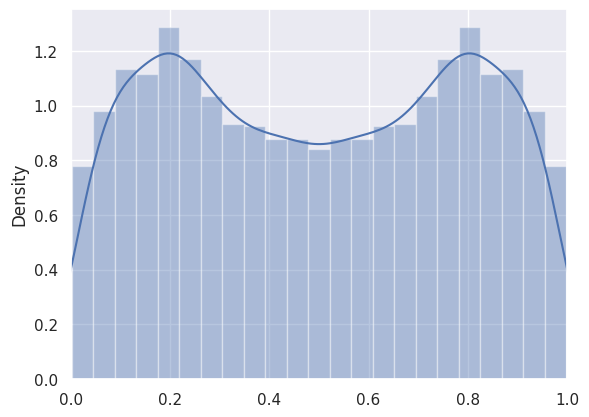

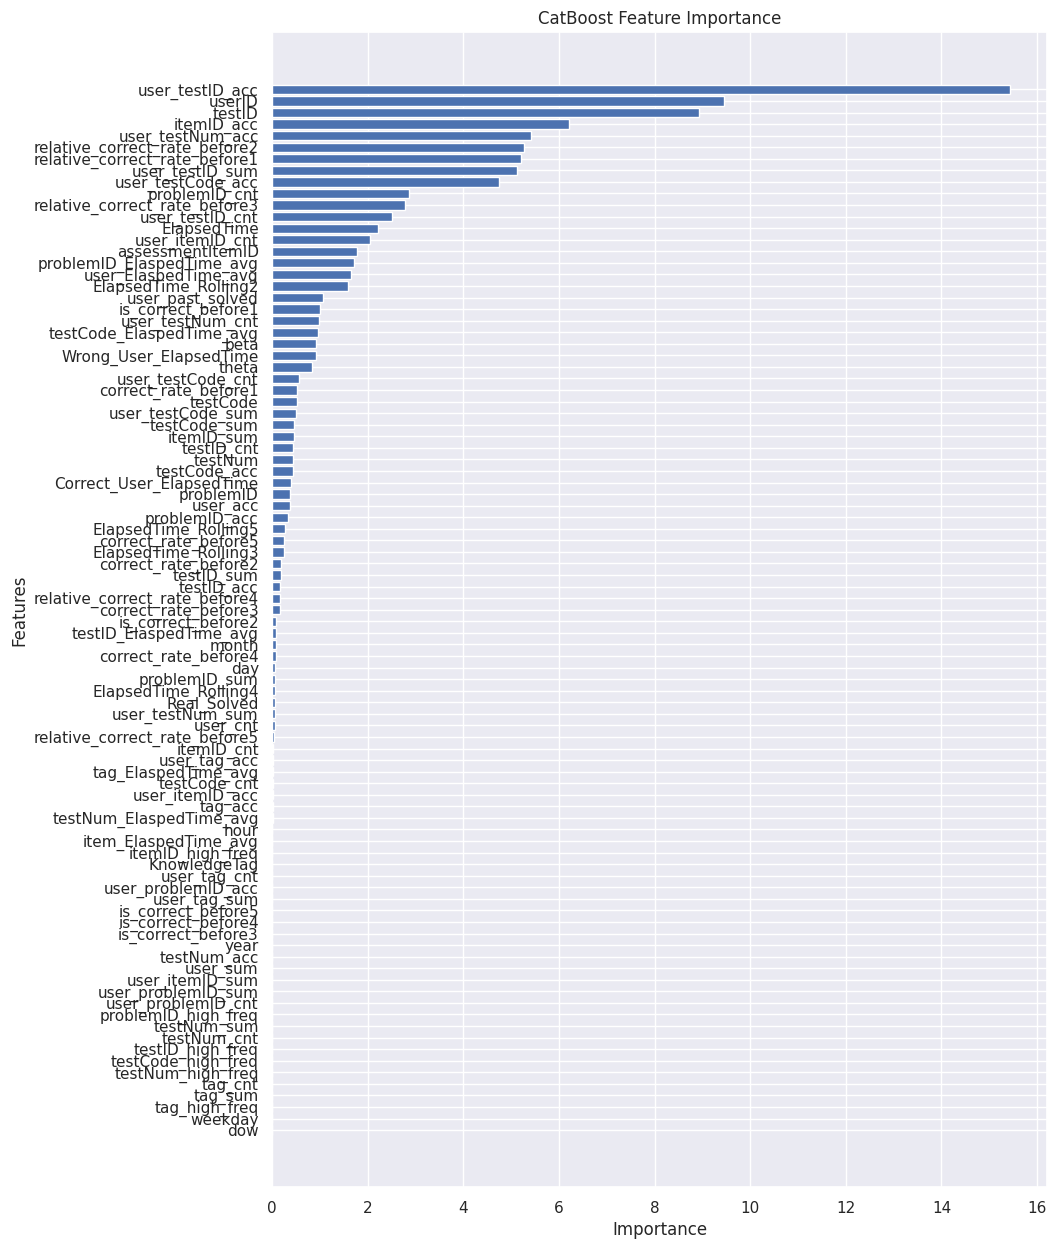

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Logloss,▁
ROC-AUC,▁
iteration@metric-period-1,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learn-Logloss,█▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation_0-AUC,▁▁▂▂▂▂▂▃▄▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
validation_0-Logloss,█▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation_1-AUC,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████
validation_1-Logloss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.76127
Logloss,0.49288


In [12]:
wandb.init(project = 'dkt-ljw', sync_tensorboard = True)
wandb.run.name = 'CATCLF_NewHPO_0115'
wandb.run.save()

train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)

# Best Parameter 학습
# param = study.best_params
param = {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 3, 'random_strength': 0.001, 'min_data_in_leaf': 7, 'subsample': 0.9180008770559941} 
# param = {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} ## Best

cat_clf = CatBoostClassifier(**param, iterations = 5000, 
                             loss_function = 'Logloss', eval_metric = 'AUC',
                             use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0',
                             cat_features = [X_train.columns.get_loc(col) for col in X_train.select_dtypes('category').columns])
cat_clf.fit(train_data, eval_set = [train_data, valid_data], verbose = 300, early_stopping_rounds = 100,
            callbacks = [CatBoostWandbCallback()])

# 모델 지표 출력
proba = cat_clf.predict_proba(X_valid)
roc_auc = roc_auc_score(y_valid, proba[:, 1])
accuracy = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
logloss = log_loss(y_valid, proba[:, 1])
wandb.log({'ROC-AUC' : roc_auc, 'Accuracy' : accuracy, 'Logloss' : logloss})
print(f'ROC-AUC Score : {roc_auc:.4f} / Accuracy : {accuracy:.4f} / Logloss : {logloss:.4f}')
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

# Feature Importance 출력
plt.figure(figsize = (10, 15))
importances = cat_clf.get_feature_importance(type = 'PredictionValuesChange') # LossFunctionChange
feature_importances = pd.Series(importances, index = X_train.columns).sort_values()
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance') ; plt.ylabel('Features') ; plt.show()
wandb.finish()

In [15]:
# cat_clf.load_model('./model/CAT_Feature91_0112')
# cat_clf.save_model('./model/CATCLF_Feature91_Wandb_0115')

360 / 744


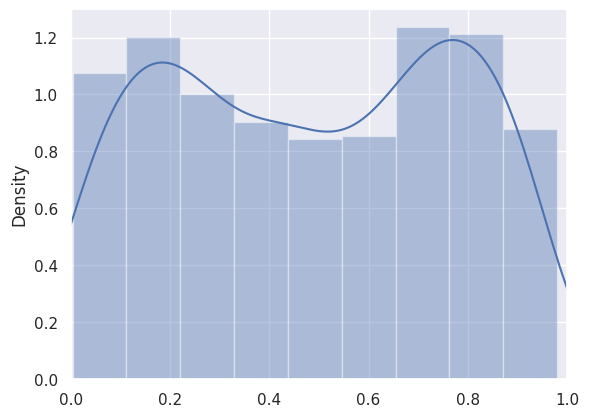

In [13]:
pred = cat_clf.predict(test_df)
proba = cat_clf.predict_proba(test_df)[:, 1]
print(f'{sum(pred)} / {len(pred)}')
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

In [14]:
# SAVE OUTPUT
output_dir = 'submit/'
write_path = os.path.join(output_dir, 'CATCLF_Feature91_NewHPO_Wandb.csv')
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
with open(write_path, 'w', encoding = 'utf8') as w :
    print('Writing Prediction : {}'.format(write_path))
    w.write('id,prediction\n')
    for id, p in enumerate(proba) : # pred
        w.write('{},{}\n'.format(id, p))

Writing Prediction : submit/CATCLF_Feature91_NewHPO_Wandb.csv


- Best trial : score 0.8337230819579381, 
    - params = {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
    - LB -> AUC : 0.8182, ACC : 0.7258
    
- Best trial : score 0.8396454244046045, 
    - params = {'learning_rate': 0.1, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 3, 'random_strength': 0.001, 'min_data_in_leaf': 7, 'subsample': 0.9180008770559941} 
    - LB -> AUC : 0.8103, ACC : 0.7339